In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [2]:
import numpy as np
import torch
import matplotlib
from matplotlib import pyplot as plt
import random
import json
import sys
sys.path.insert(0,'/home/brysongray/tractography/')
import dqn_tracker
import tracking_env
import train_dqn_tracker
from load_data import load_data
from tracking_env import Environment
from dqn_tracker import DQNModel

In [3]:
def show_state(env):
    state = env.get_state()[0]
    true_density_patch, _ = env.true_density.crop(env.paths[env.head_id][-1], env.radius, pad=True)
    I = np.array(env.img.data.to('cpu'))
    D = np.array(env.true_density.data.to('cpu'))
    O = np.array(state.to('cpu'))
    T = np.array(true_density_patch.to('cpu'))
    fig, ax = plt.subplots(1,4)
    ax[0].imshow(I[-1].max(axis=0))#, int(env.paths[env.head_id][-1, 0])])
    ax[1].imshow(D[0].max(axis=0))#, int(env.paths[env.head_id][-1, 0])])
    ax[2].imshow(O[0,-1].max(axis=0))#, env.radius//2])
    ax[3].imshow(T[0].max(axis=0))#, env.radius//2])
    plt.show()

def get_closest_dir(action_space, dir):
    d = np.dot(action_space, dir[:,None])
    idx = d.argmax()

    return idx

In [9]:
f = open('/home/brysongray/tractography/neuron_trx/configs/config.json')
args = json.load(f)

img_file = args["image"]
label_file = args["label"]
seeds = args["seeds"]
model = args["model"] if "model" in args else None
n_seeds = args["n_seeds"] if "n_seeds" in args else 1
step_size = args["step_size"] if "step_size" in args else 1.0
batch_size = args["batchsize"] if "batchsize" in args else 128
gamma = args["gamma"] if "gamma" in args else 0.99
eps_start = args["eps_start"] if "eps_start" in args else 0.9
eps_end = args["eps_end"] if "eps_end" in args else 0.01
eps_decay = args["eps_decay"] if "eps_decay" in args else 1000
tau = args["tau"] if "tau" in args else 0.001
lr = args["lr"] if "lr" in args else 1e-4
alpha = args["alpha"] if "alpha" in args else 1.0
beta = args["beta"] if "beta" in args else 1e-3
friction = args["friction"] if "friction" in args else 1e-4
num_episodes = args["num_episodes"] if "num_episodes" in args else 100
pixelsize = args["pixelsize"] if "pixelsize" in args else [1.0, 1.0, 1.0]
patch_radius = 12
actions = np.load('/home/brysongray/tractography/neuron_trx/action_space_40_dir.npy')

img, density, mask = load_data(img_file, label_file, downsample_factor=10)


env = Environment(img,
                    patch_radius,
                    seeds,
                    mask,
                    density,
                    actions,
                    n_seeds=1,
                    step_size=step_size,
                    pixelsize=pixelsize,
                    max_len=10000,
                    alpha=alpha,
                    beta=beta,
                    friction=friction)

dqn_model = DQNModel(in_channels=4,
                        n_actions=len(actions),
                        input_size=(2*patch_radius+1),
                        lr=lr)

if model:
    dqn_model.load_model(torch.load(model))



/home/brysongray/tractography/data/Cerebellar Climbing Fibers/Gold Standard Reconstructions/CF_1.swc:1506:warning

/home/brysongray/tractography/data/Cerebellar Climbing Fibers/Gold Standard Reconstructions/CF_1.swc:1493:warning

/home/brysongray/tractography/data/Cerebellar Climbing Fibers/Gold Standard Reconstructions/CF_1.swc:1322:warning

/home/brysongray/tractography/data/Cerebellar Climbing Fibers/Gold Standard Reconstructions/CF_1.swc:1216:warning

/home/brysongray/tractography/data/Cerebellar Climbing Fibers/Gold Standard Reconstructions/CF_1.swc:1118:warning

/home/brysongray/tractography/data/Cerebellar Climbing Fibers/Gold Standard Reconstructions/CF_1.swc:0:warning


In [11]:
DEVICE = 'cuda:0'

In [12]:
steps_done = 0
episode_durations = []
episode_returns = []

env.reset()
state = env.get_state()[0].clone().to(dtype=torch.float32, device=DEVICE)
ep_return = 0

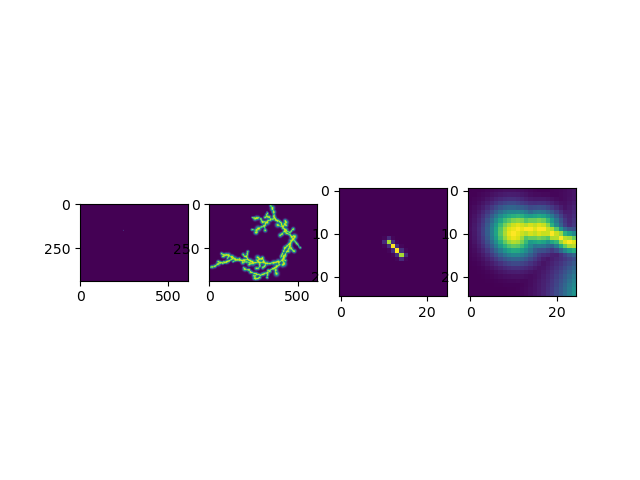

In [14]:
show_state(env)

tensor([3.7412], device='cuda:0')


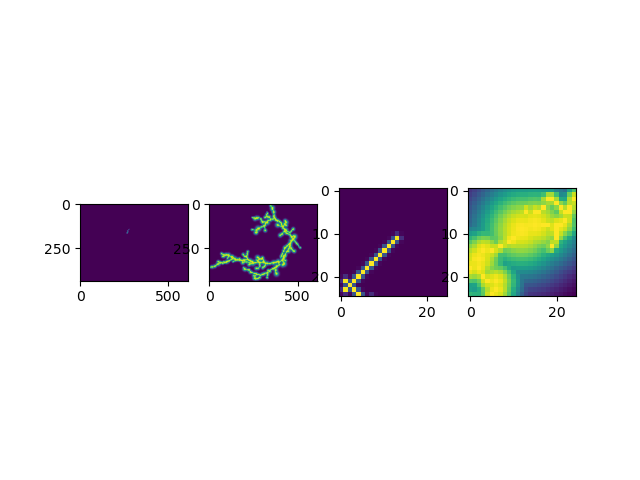

In [61]:
plt.close('all')
action = torch.tensor([0., -1.0, 1.0])
observation, reward, terminated = env.step(action)
print(reward)
show_state(env)

In [49]:
env.reset()

In [ ]:
# get the index of action_space closest to a desired step direction
action_id = get_closest_dir(env.action_space, torch.Tensor([0., 0., -1.]))
print(action_id)
print(env.action_space[action_id])

In [ ]:
for i in range(10):
    action_id = dqn_model.select_action(env.action_space, state, steps_done, eps_start, eps_end, eps_decay)
    # observation, reward, terminated = env.step(env.action_space[action_id])

    # step
    terminated = False

    action = env.action_space[action_id]
    # action = torch.Tensor([0.0, 0.0, 1.0])

    # add new position to path
    env.paths[env.head_id] = torch.cat((env.paths[env.head_id], (env.paths[env.head_id][-1] + env.step_size*action)[None]))
    # decide if path terminates
    out_of_bound = any([x >= y or x < 0 for x,y in zip(torch.round(env.paths[env.head_id][-1]), env.img.data.shape[1:])])
    # out_of_mask = env.mask[tuple([int(x) for x in env.paths[env.head_id][-1]])]
    too_long = len(env.paths[env.head_id]) > env.max_len
    self_terminate = not any(action)
    terminate_path = out_of_bound or too_long or self_terminate

    if terminate_path:
        observation = None
        reward = torch.tensor([0.], device=DEVICE)
        # remove the path from 'paths' and add it to 'ended_paths'
        env.ended_paths.append(env.paths.pop(env.head_id))
        # if that was the last path in the list, then terminate the episode
        if len(env.paths) == 0:
            terminated = True
        else:
            env.head_id = (env.head_id + 1)%len(env.paths)
    else:
        center = env.paths[env.head_id][-2]
        r = env.radius + int(np.ceil(env.step_size.max()))
        true_density_patch, padding = env.true_density.crop(center, radius=r) # patch centered at previous step position
        old_density_patch, _ = env.img.crop(center, radius=r)
        old_density_patch = old_density_patch.detach().clone()[-1][None] # need to make a copy or else this will be modified by adding a point to img
        # add_bundle_point(self.img, self.paths[self.head_id][-1], self.ball)
        segment = env.paths[env.head_id][-2:, :3]
        env.img.draw_line_segment(segment, width=1.0)
        new_density_patch, _ = env.img.crop(center, radius=r)
        new_density_patch = new_density_patch[-1][None]
        delta_density_diff = tracking_env.density_error_change(true_density_patch, old_density_patch, new_density_patch)
        observation = env.get_state()
        reward = env.get_reward(terminated, delta_density_diff)

        env.head_id = (env.head_id + 1)%len(env.paths)
    # end step

    ep_return += reward

    if terminated: # episode terminated
        next_state = None
        break
    else:
        next_state = observation # if the streamline terminated, the observation is None
        if next_state is not None:
            next_state = next_state[0].clone().to(dtype=torch.float32, device=DEVICE)
    
    dqn_model.memory.push(state, action_id, next_state, reward)

    # if not terminated, move to the next state
    state = env.get_state()[0].to(dtype=torch.float32, device=DEVICE) # the head of the next streamline

print(type(observation),'\n',
    reward,'\n',
    terminated,'\n',
    len(env.paths)
)

true_density = true_density_patch / (true_density_patch.sum() + np.finfo(float).eps)
old_density = old_density_patch / (old_density_patch.sum() + np.finfo(float).eps)
new_density = new_density_patch / (new_density_patch.sum() + np.finfo(float).eps)
fig, ax = plt.subplots(1,3)
ax[0].imshow(true_density[0, r-padding[0]])#, vmax=(true_density.mean() + np.finfo(float).eps))
ax[1].imshow(old_density[0, r-padding[0]])#, vmax=(true_density.mean() + np.finfo(float).eps))
ax[2].imshow(new_density[0, r-padding[0]])#, vmax=(true_density.mean() + np.finfo(float).eps))

In [ ]:
show_state(env)

In [ ]:
# Store the transition in memory
dqn_model.memory.push(state, action_id, next_state, reward)

In [ ]:
# Perform one step of the optimization (on the policy network)
dqn_model.optimize_model(batch_size, gamma)

In [ ]:
# Soft update of the target network's weights
# θ′ ← τ θ + (1 −τ )θ′
target_net_state_dict = dqn_model.target_net.state_dict()
policy_net_state_dict = dqn_model.policy_net.state_dict()
for key in policy_net_state_dict:
    target_net_state_dict[key] = policy_net_state_dict[key]*tau + target_net_state_dict[key]*(1-tau)
dqn_model.target_net.load_state_dict(target_net_state_dict)

In [ ]:
if terminated:
    episode_durations.append(t + 1)
    episode_returns.append(ep_return)
    print('Terminated')

In [ ]:
config_path = "/home/brysongray/tractography/neuron_trx/configs/config.json"
f = open(config_path)
config = json.load(f)
print(type(config))

In [ ]:
train_dqn_tracker.main(config)

In [ ]:
fname = '/home/brysongray/tractography/outputs/bundle_density_ep3220.pt'
density = torch.load(fname)
print(density.shape)

In [ ]:
plt.close('all')

In [ ]:
# fig, ax = plt.subplots(1,2)
# ax[0].imshow(density[19])
# ax[1].imshow(env.true_density[0,19])
plt.figure()
vmax1 = np.percentile(density[19], 100)
vmax2 = np.percentile(env.true_density[0,19], 100)
D = density[19] / vmax1
T = env.true_density[0,19] / vmax2
plt.imshow(D, cmap='hot', alpha=0.7)#, vmax=vmax1)
plt.imshow(T, cmap='gray', alpha=0.3)#, vmax=vmax2)


In [ ]:
plt.figure()
toshow = env.img[:-1, 19].permute(1,2,0) / env.img[:-1, 19].max()
plt.imshow(toshow)